In [19]:
import os
import numpy as np
import pandas as pd
import pickle as pl

os.chdir("/Users/cornederuijt/github/GCM/")  # Adjust after construction of the package

from scripts.clickmodel_fitters.clickdefinitionreader import ClickDefinition
from scripts.clickmodel_fitters.GCM import GCM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import Identity, Zeros
import tensorflow as tf
from tensorflow.linalg import LinearOperatorFullMatrix
from tensorflow.linalg import LinearOperatorKronecker
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tensorflow.keras.constraints import Constraint

from plotnine import *


np.random.seed(1992)

In [12]:
class UBMLayer(Layer):
    def __init__(self, units=11):
        super(UBMLayer, self).__init__()
        self.units = units

    def build(self, input_shape):  # Create the state of the layer (weights)
        T = self.units  # As we exclude the zero state for now
        zero_init = tf.random_normal_initializer()

        # T-1: as T includes the 0 state, which the matrix does not
        self._w = tf.Variable(initial_value=zero_init(shape=(int(T * (T - 1) / 2),), dtype='float32'), trainable=True)

        # Create the index matrices
        self._I_end = tf.constant([[0, 0, 0, 1],
                                 [0, 0, 0, 1],
                                 [0, 0, 0, 1],
                                 [0, 0, 0, 1]], dtype="float32")

        self._I_neg = tf.math.subtract(tf.ones((4, 4), dtype='float32'), self._I_end)

    def call(self, inputs, **kwargs):  # Defines the computation from inputs to outputs
        # print(tf.shape(inputs)[0])
        N = inputs.shape[0]
        T = self.units

        n_states = T * 4 + 1
        inp_lst = []

        wout = tfp.math.fill_triangular(self._w, upper=True)

        for t in range(N):
            cur_input = tf.gather(inputs, t, axis=0)
            cur_input = tf.tile(tf.reshape(cur_input, shape=(1, -1)), [T - 1, 1])
            logis = tf.multiply(cur_input, wout)

            logis_vec = tf.gather(wout, t % (T-1), axis=1)

            res1 = LinearOperatorKronecker([LinearOperatorFullMatrix(logis),
                                            LinearOperatorFullMatrix(self._I_end)]).to_dense()

            # n_states - 5, as the absorbing state and the last 4 are not included yet
            res1 = tf.concat([tf.zeros([n_states - 5, 4]), res1, tf.zeros([n_states - 5, 1])], axis=1)
            res1 = tf.concat([res1, np.zeros((5, n_states))], axis=0)

            res2 = LinearOperatorKronecker(
                [LinearOperatorFullMatrix(tf.linalg.diag(logis_vec)),
                 LinearOperatorFullMatrix(self._I_neg)]).to_dense()

            res2 = tf.concat([tf.concat([res2, tf.zeros([n_states - 5, 5])], axis=1), tf.zeros([5, n_states])], axis=0)

            res_all = tf.math.add(res1, res2)
            mask = tf.cast(tf.math.not_equal(res_all, tf.constant(0, dtype="float32")), dtype="float32")
            res_all = tf.math.multiply(res_all, mask)

            inp_lst.append(tf.reshape(res_all, shape=(-1, 1)))

        res = tf.concat(inp_lst, axis=0)

        return res

    def get_config(self):
        return {"units": self.units,
                "mask": self._wout_mask}

In [8]:
# Define the model
list_size = 10
no_states = (list_size + 1) * 4 + 1  # +1 is the absorbing state
ubm_click_states = np.zeros((no_states, list_size+1))
ubm_click_states[:-1, :] = np.kron(np.eye(list_size+1), np.expand_dims(np.array([0, 0, 0, 1]), axis=1))

# i.e., number of states minus 1, as we have a zero-based index
abs_state = [(i, (list_size + 1) * 4) for i in range(no_states)]
init_state = 3  # Corresponding with (0,1,1), i.e., the zero position was evaluated and clicked
batch_size = 10000
no_items = 100

# Positive matrix for A:
phi_A_diag = np.vstack((np.hstack((np.kron(np.eye(list_size + 1), np.tile(np.array([0, 0, 1, 0]), (4, 1))),
                                   np.zeros((no_states-1, 1)))),
                                   np.zeros(no_states)))

phi_upper_tr = np.triu(np.tile(np.hstack((np.zeros(4), np.tile(np.eye(4)[3], list_size), np.zeros(1))), (no_states, 1)),
                        k=4)
phi_A_pos = phi_A_diag + phi_upper_tr

# Negative matrix for A:
phi_A_neg = np.vstack((np.hstack((np.kron(np.eye(list_size + 1), np.tile(np.array([1, 1, 0, 0]), (4, 1))),
                                   np.zeros((no_states-1, 1)))),
                                   np.zeros(no_states)))

# Positive matrix for gamma:
gamma_diag = np.vstack((np.hstack((np.kron(np.eye(list_size + 1), np.tile(np.array([0, 1, 0, 0]), (4, 1))),
                                   np.zeros((no_states-1, 1)))),
                                   np.zeros(no_states)))

gamma_upper_tr = np.triu(np.tile(np.hstack((np.zeros(4), np.tile(np.eye(4)[3], list_size), np.zeros(1))), (no_states,1))
                      ,k=4)
gamma_pos = gamma_diag + gamma_upper_tr

# Negative matrix for gamma:
gamma_neg = np.vstack((np.hstack((np.kron(np.eye(list_size + 1), np.tile(np.array([1, 0, 1, 0]), (4, 1))),
                                   np.zeros((no_states-1, 1)))),
                                   np.zeros(no_states)))

var_dic = {
    'phi_A': {
        'var_type': 'item',
        'pos_mat': phi_A_pos,
        'neg_mat': phi_A_neg
    },
    'gamma': {
        'var_type': 'pos',
        'pos_mat': gamma_pos,
        'neg_mat': gamma_neg
    }
}

model_def = ClickDefinition(ubm_click_states, init_state, list_size, no_states, batch_size, no_items, abs_state,
                            var_dic)

In [9]:
# Load data:
click_data = pd.read_csv("./data/small_example/simulation_res_train.csv", index_col=False)
prod_position = pd.read_csv("./data/small_example/simulation_item_props.csv", index_col=False)

# Ensure the order is correct:
click_data = click_data.sort_values(['user_id', 'session_count', 'item_order'])

# Add session index:
session_index = (click_data
                 .loc[:, ['user_id', 'session_count']]
                 .drop_duplicates()
                 .reset_index()
                 )

session_index['session'] = session_index.index.to_numpy()

click_data = (click_data
              .set_index(['user_id', 'session_count'])
              .join(session_index
                    .set_index(['user_id', 'session_count']),
                    on=['user_id', 'session_count'])
              .reset_index()
              .set_index('item')
              .join(prod_position
                    .set_index('item'),
                    on='item')
              .reset_index()
              )

In [10]:
# Create the click matrix and item position matrix
click_mat = click_data.loc[:, ['session', 'item_order', 'click']] \
    .pivot(index='session', columns='item_order', values='click') \
    .to_numpy()

item_pos_mat = click_data.loc[:, ['session', 'item_order', 'item']] \
    .pivot(index='session', columns='item_order', values='item') \
    .to_numpy()

# Ensure the order is correct
item_feature_mat_A = (click_data.loc[:, ['item', 'X0', 'X1']]
                                .drop_duplicates()
                                .sort_values('item')
                                .to_numpy())

# pos_feature_mat_tau_lst = []
#
# pos_feature_mat_tau = np.vstack([np.hstack((np.zeros((model_def.list_size + 1, k1)),
#             np.hstack((np.ones(k1), np.zeros(model_def.list_size - k1 + 1))).reshape(-1, 1),
#             np.zeros((model_def.list_size + 1, model_def.list_size - k1)))).flatten()
#  for k1 in range(1, model_def.list_size+1)])

pos_feature_gamma = np.eye(model_def.list_size)

var_dic = {'phi_A': item_feature_mat_A, 'gamma': pos_feature_gamma}


In [13]:
# Model:
model_phi_A = Sequential()
model_phi_A.add(Dense(1, input_dim=var_dic['phi_A'].shape[1], activation='sigmoid', use_bias=False))
model_phi_A.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

# Note the large output dimension and the softmax. We want multiple transition probabilities that sum up to 1
# Its the shape**2, as we flatten the square matrix.
model_gamma = Sequential()
model_gamma.add(UBMLayer(list_size + 1))
model_gamma.compile(loss=GCM.pos_log_loss, optimizer=RMSprop())

var_models = {'phi_A': model_phi_A, 'gamma': model_gamma}

In [14]:
res = GCM.runEM(click_mat, var_dic, var_models, item_pos_mat, model_def, verbose=True)

Iteration: 0
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
Running E-step ...
Current conditional entropy:1.65532
Running M-step ...
Iteration: 1
Current norm: 0.3174
Running E-step ...
Current conditional entropy:1.62543
Running M-step ...
Iteration: 2
Current norm: 0.33871
Running E-step ...
Current conditional entropy:1.57097
Running M-step ...
Iteration: 3
Current norm: 1.87471
Running E-step ...
Current conditional entropy:1.0267
Running M-step ...
Iteration: 4
Current norm: 1.37792
Running E-step ...
Current conditional entropy:0.87144
Running M-step ...
Iteration: 5
Current norm: 1.14748
Running E-step ...
Current conditional entropy:0.80896
Running M-step ...
Iteration: 6
Current norm: 0.78987
Running E-step ...
Current conditional entropy:0.77564
Running M-step ...
Iteration: 7
Current norm: 0.67432
Running E-step ...
Current conditional entropy:0.75077
Running M-step ...
Iteration

In [17]:
pl.dump(res[1:], open("./results/ubm_res.pl", 'wb')) 

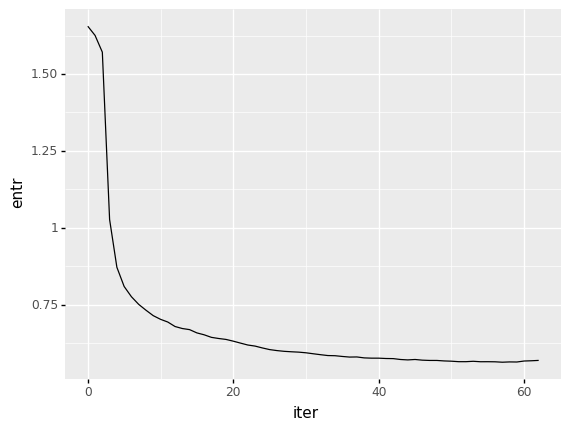

<ggplot: (8776754755615)>

In [20]:
(ggplot(pd.DataFrame(np.hstack((np.arange(len(res[2])).reshape(-1, 1), np.array(res[2]).reshape(-1 ,1))),
            columns=['iter', 'entr'])) +
 geom_line(aes(x='iter', y='entr'))
)



In [21]:
phi_A_all = []
gamma_all = []
for param_val in res[1]:
    phi_A_all.append(param_val['phi_A'].reshape(-1, 1))
    gamma_all.append(param_val['gamma'][0])

phi_A_mat = np.hstack(phi_A_all)
gamma_mat = np.hstack(gamma_all)

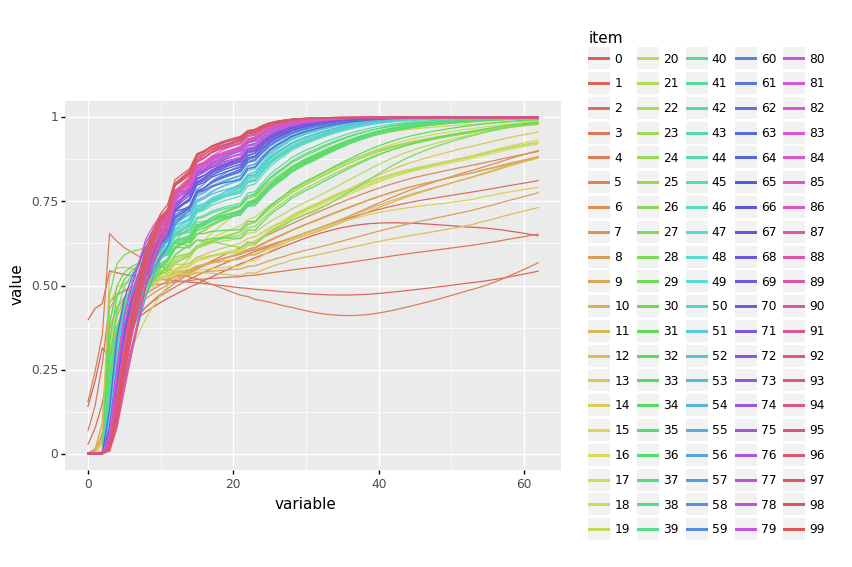

<ggplot: (8776754755675)>

In [22]:
phi_A_pd = pd.DataFrame(phi_A_mat)
phi_A_pd['item'] = np.arange(phi_A_pd.shape[0])
phi_A_pd = pd.melt(phi_A_pd, id_vars=['item'])
phi_A_pd['variable'] = phi_A_pd['variable'].astype(float)
phi_A_pd['item'] = phi_A_pd['item'].astype('category')

(ggplot(phi_A_pd) +
geom_line(aes(x='variable', y='value', color='item'))
)

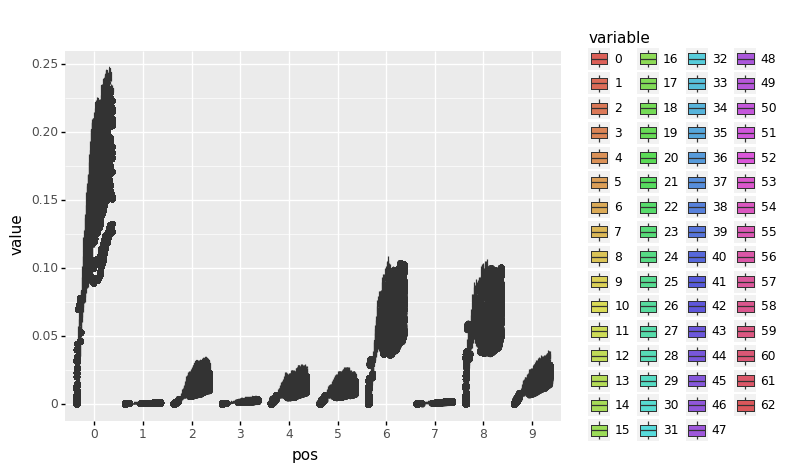

<ggplot: (8775945822142)>

In [23]:
click_probs = [prob.reshape(-1, 1) for prob in res[3]]
click_probs_pd = pd.DataFrame(np.hstack(click_probs))
click_probs_pd['pos'] = np.tile(np.arange(10), int(click_probs_pd.shape[0]/10))
click_probs_pd['pos'] = click_probs_pd['pos'].astype('category')
click_probs_pd

click_probs_pd_flat = pd.melt(click_probs_pd, id_vars=['pos'])
click_probs_pd_flat['variable'] = click_probs_pd_flat['variable'].astype('category')

(ggplot(click_probs_pd_flat) +
 geom_boxplot(aes(x='pos', y='value', fill='variable'))
)



In [43]:
perplex_table = (pd.concat((click_data['item_order'], pd.Series(res[3][62]), click_data['click']), axis=1)
                 .rename(columns={0: 'est'}))

perplex_table = perplex_table.assign(
    entr = perplex_table['click']*np.log2(perplex_table['est'])+
        (1-perplex_table['click'])*np.log2(1-perplex_table['est']))


perp_dat = (perplex_table
     .groupby('item_order')
     .agg({'entr': 'mean'})
     .reset_index()
     .set_index("item_order")
     .join(perplex_table[perplex_table['click']==1]
               .groupby('item_order')
                 .agg({'entr': 'mean'})
                 .reset_index()
                 .rename(columns={'entr': 'pos_entr'})
                 .set_index("item_order"),
           on='item_order')
     .join(perplex_table[perplex_table['click']==0]
           .groupby('item_order')
             .agg({'entr': 'mean'})
             .reset_index()
             .rename(columns={'entr': 'neg_entr'})
             .set_index("item_order"),
       on='item_order')      
     .assign(perplexity=lambda x: 2**(-x.entr),
            pos_perplexity=lambda x: 2**(-x.pos_entr),
            neg_perplexity=lambda x: 2**(-x.neg_entr))
    .reset_index()
)







In [44]:
perp_dat.to_csv("./results/UBM_perplexity.csv", index=False)